In [ ]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 25kB/s 
     |████████████████████████████████| 460kB 67kB/s 
     |████████████████████████████████| 3.0MB 51.4MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 1.0.0
    Uninstalling tensorflow-1.0.0:
      Successfully uninstalled tensorflow-1.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import numpy as np
import random
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Concatenate
from keras import optimizers
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from matplotlib import pyplot as plt
import math

In [ ]:
import keras, tensorflow as tf
print(keras.__version__)
tf.__version__
# !python --version

2.4.3


'2.2.0'

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
num_classes = 3
epochs = 100

In [ ]:
def euclidean_distance(vects):
    x,y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1-y_true) * margin_square)

In [ ]:
def create_pairs(x, digit_indices):
    
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]] # positive sample
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] # negative sample
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [ ]:
def create_pairs_per_class(x, digit_indices, class_1, class_2):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for i in range(n):
        z1, z2 = digit_indices[class_1][i], digit_indices[class_1][i + 1]
        pairs += [[x[z1], x[z2]]] # positive sample
        z1, z2 = digit_indices[class_1][i], digit_indices[class_2][i] # negative sample
        pairs += [[x[z1], x[z2]]]
        labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [ ]:
# def create_base_network(input_shape):
#     '''Base network to be shared (eq. to feature extraction).
#     '''
#     input = Input(shape=input_shape)
#     x = Flatten()(input)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='relu')(x)
#     return Model(input, x)

In [ ]:
def fire_module(x, s1x1, e1x1, e3x3, name):
    #Squeeze layer
    squeeze = Conv2D(s1x1, (1, 1), activation='relu', padding='valid', kernel_initializer='glorot_uniform', name = name + 's1x1')(x)
    squeeze_bn = BatchNormalization(name=name+'sbn')(squeeze)
    
    #Expand 1x1 layer and 3x3 layer are parallel

    #Expand 1x1 layer
    expand1x1 = Conv2D(e1x1, (1, 1), activation='relu', padding='valid', kernel_initializer='glorot_uniform', name = name + 'e1x1')(squeeze_bn)
    
    #Expand 3x3 layer
    expand3x3 = Conv2D(e3x3, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform', name = name +  'e3x3')(squeeze_bn)
    
    #Concatenate expand1x1 and expand 3x3 at filters
    output = Concatenate(axis = 3, name=name)([expand1x1, expand3x3])
    
    return output
  
def SqueezeNet(input_shape):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(96, kernel_size=(3, 3), strides=(2, 2),  padding='same', activation='relu', name = 'Conv1')(inputs)
    maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='Maxpool1')(conv1)
    batch1 = BatchNormalization(name='Batch1')(maxpool1)
#     fire2 = fire_module(batch1, 16, 64, 64, "Fire2")
#     fire3 = fire_module(fire2, 16, 64, 64, "Fire3")
    fire4 = fire_module(batch1, 32, 128, 128, "Fire2")
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='Maxpool2')(fire4)
#     fire5 = fire_module(maxpool4, 32, 128, 128, "Fire5")
    fire6 = fire_module(maxpool4, 48, 192, 192, "Fire3")
    fire7 = fire_module(fire6, 48, 192, 192, "Fire4")
    fire8 = fire_module(fire7, 48, 192, 192, "Fire5")
    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='Maxpool5')(fire8)
#     fire9 = fire_module(maxpool8, 64, 256, 256, "Fire9")
    dropout = Dropout(0.5, name="Dropout")(maxpool8)
    conv10 = Conv2D(10, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name='Conv6')(dropout)
    batch10 = BatchNormalization(name='Batch6')(conv10)
    avgpool10 = GlobalAveragePooling2D(name='GlobalAvgPool6')(batch10)
    #softmax = Activation('softmax')(avgpool10)
    
    squeezenet = Model(inputs=inputs, outputs=avgpool10)
    return squeezenet
  
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    return SqueezeNet(input_shape)

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
(x_traino, y_traino), (x_testo, y_testo) = cifar10.load_data()

print(x_traino.shape)
print(y_traino.shape)
print(x_testo.shape)
print(y_testo.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
import copy

(x_traino, y_traino), (x_testo, y_testo) = cifar10.load_data()

x_train = []
y_train = []
x_test = []
y_test = []
for i in range (len(y_traino)):
    if y_traino[i] == 1:
      y_traino[i] = 0
      x_train.append(x_traino[i])
      y_train.append(y_traino[i])
    if y_traino[i] == 5:
      y_traino[i] = 1
      x_train.append(x_traino[i])
      y_train.append(y_traino[i])
    if y_traino[i] == 7:
      y_traino[i] = 2
      x_train.append(x_traino[i])
      y_train.append(y_traino[i])

for i in range (len(y_testo)):
    if y_testo[i] == 1:
      y_testo[i] = 0
      x_test.append(x_testo[i])
      y_test.append(y_testo[i])
    if y_testo[i] == 5:
      y_testo[i] = 1
      x_test.append(x_testo[i])
      y_test.append(y_testo[i])
    if y_testo[i] == 7:
      y_testo[i] = 2
      x_test.append(x_testo[i])
      y_test.append(y_testo[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


x_train_unnormalized = copy.deepcopy(x_train)
y_train_unnormalized = copy.deepcopy(y_train)
x_test_unnormalized = copy.deepcopy(x_test)
y_test_unnormalized = copy.deepcopy(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
print(input_shape)

(15000, 32, 32, 3)
(15000, 1)
(3000, 32, 32, 3)
(3000, 1)
(32, 32, 3)


In [ ]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [ ]:
print("Shape of training pairs", tr_pairs.shape)
print("Shape of training labels", tr_y.shape)

Shape of training pairs (29994, 2, 32, 32, 3)
Shape of training labels (29994,)


In [ ]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape, name='input_a')
input_b = Input(shape=input_shape, name='input_b')

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

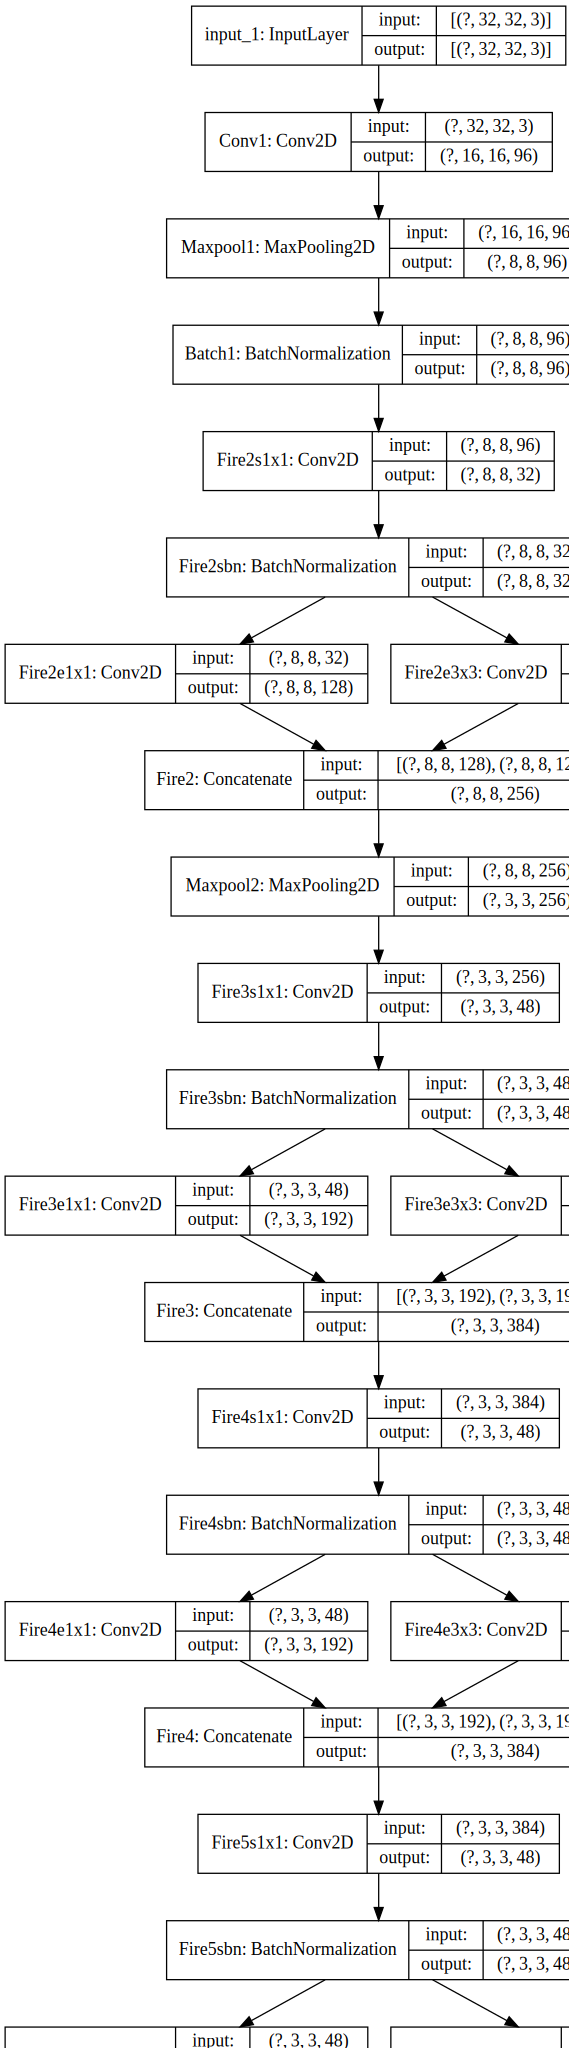

In [ ]:
SVG(model_to_dot(base_network, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 10)           378914      input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

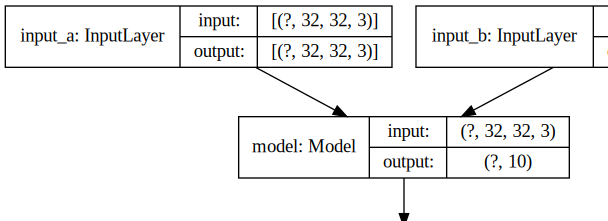

In [ ]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
checkpointer = ModelCheckpoint(filepath='model.hfs5', save_best_only=True)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=epochs, validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y), callbacks=[checkpointer])

Epoch 1/100
235/235 [==============================] - ETA: 0s - loss: 3.9350 - accuracy: 0.5403WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model.hfs5/assets
235/235 [==============================] - 9s 40ms/step - loss: 3.9350 - accuracy: 0.5403 - val_loss: 1.7228 - val_accuracy: 0.6499
Epoch 2/100
235/235 [==============================] - 9s 37ms/step - loss: 0.7765 - accuracy: 0.6527 - val_loss: 1.0227 - val_accuracy: 0.6475
Epoch 3/100
235/235 [==============================] - 9s 36ms/step - loss: 0.3144 - accuracy: 0.7376 - val_loss: 0.3708 - val_accuracy: 0.7229
Epoch 4/100
235/235 [==============================] - 9s 37ms/step - loss

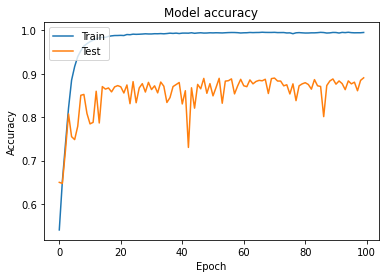

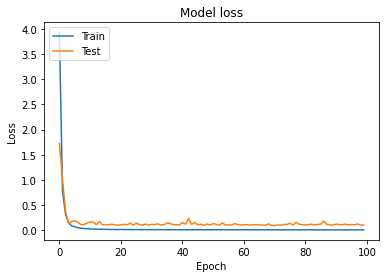

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

In [ ]:
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.52%
* Accuracy on test set: 89.07%


In [ ]:
model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y)

188/188 [==============================] - 1s 5ms/step - loss: 0.1024 - accuracy: 0.8911


[0.10238345712423325, 0.8911236524581909]

In [ ]:
# model = load_model('model.hfs5', custom_objects={'contrastive_loss':contrastive_loss})

In [ ]:
model.save('gdrive/My Drive/colab_notebooks/model.h5')

# model.save_model( 'gdrive/My Drive/colab_notebooks/model.hfs5')

In [ ]:
model = load_model('gdrive/My Drive/colab_notebooks/model.h5', custom_objects={'contrastive_loss':contrastive_loss})

In [ ]:
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
for i in range(num_classes):
  for j in range(num_classes):
    print(i, j)
    te_pairs, te_y = create_pairs_per_class(x_test, digit_indices, i, j)
    result = model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y)
    print(result)

0 0
63/63 [==============================] - 0s 5ms/step - loss: 0.5265 - accuracy: 0.5280
[0.526484489440918, 0.5280280113220215]
0 1
63/63 [==============================] - 0s 5ms/step - loss: 0.0385 - accuracy: 0.0425
[0.03850114345550537, 0.04254254326224327]
0 2
63/63 [==============================] - 0s 4ms/step - loss: 0.0358 - accuracy: 0.0390
[0.03582102432847023, 0.03903903812170029]
1 0
63/63 [==============================] - 0s 5ms/step - loss: 0.0635 - accuracy: 0.0731
[0.06353557109832764, 0.07307307422161102]
1 1
63/63 [==============================] - 0s 4ms/step - loss: 0.5515 - accuracy: 0.5586
[0.5515188574790955, 0.5585585832595825]
1 2
63/63 [==============================] - 0s 4ms/step - loss: 0.1331 - accuracy: 0.1522
[0.13309404253959656, 0.1521521508693695]
2 0
63/63 [==============================] - 0s 4ms/step - loss: 0.1119 - accuracy: 0.1386
[0.11190791428089142, 0.13863864541053772]
2 1
63/63 [==============================] - 0s 4ms/step - loss: 0.1

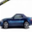

In [ ]:
import imageio
from PIL import Image

testimage = x_test_unnormalized[27].astype('float32')
testimage /= 255

referenceimage = x_test_unnormalized[27].astype('float32')
referenceimage /= 255

from PIL import Image
im = Image.fromarray(x_test_unnormalized[27])
display(im)
# im.save("your_file.jpeg")




In [ ]:
import imageio
from PIL import Image

carimage = imageio.imread('gdrive/My Drive/colab_notebooks/data/test/automobile/automobile6.png')
np.array(carimage)

array([[[160,  37,  13],
        [185,  49,  11],
        [209,  57,  14],
        ...,
        [101,  18,   8],
        [ 91,  21,   6],
        [ 94,  19,   5]],

       [[225,  67,  13],
        [239,  72,  12],
        [242,  77,  10],
        ...,
        [107,  21,   8],
        [ 97,  22,   4],
        [100,  18,   6]],

       [[252,  72,   7],
        [249,  68,   4],
        [241,  72,   3],
        ...,
        [115,  20,   6],
        [105,  19,   3],
        [105,  17,   6]],

       ...,

       [[ 80,  33,  33],
        [ 89,  37,  40],
        [ 81,  39,  44],
        ...,
        [ 11,  14,  11],
        [ 21,  24,  21],
        [ 33,  29,  28]],

       [[ 73,  35,  37],
        [ 79,  37,  41],
        [ 73,  41,  48],
        ...,
        [ 15,  20,  18],
        [ 27,  31,  29],
        [ 31,  30,  28]],

       [[ 69,  42,  44],
        [ 72,  42,  49],
        [ 76,  59,  70],
        ...,
        [ 26,  28,  31],
        [ 30,  32,  34],
        [ 29,  30,  28]]

array([1.        , 1.        , 1.        , ..., 0.99215686, 0.99215686,
       0.99215686])

In [ ]:
testimage = testimage.reshape(1, 32 ,32 , 3)
referenceimage = referenceimage.reshape(1,32,32,3)

In [ ]:
pred = model.predict([testimage, referenceimage])

In [ ]:
print(pred)

[[0.00031623]]


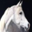

In [ ]:
from PIL import Image
im = Image.fromarray(x_test_unnormalized[28])
display(im)

In [1]:
!python 'gdrive/My Drive/colab_notebooks/script.py' -i 'gdrive/My Drive/colab_notebooks/testimage.png' -d 'gdrive/My Drive/colab_notebooks/data_test/'


Verified, images in path:300
2020-09-07 23:31:00.795173: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-09-07 23:31:00.828947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-07 23:31:00.829502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-09-07 23:31:00.829814: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-09-07 23:31:00.831197: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-07 23:31:00.832702: I tensorflow/stre

In [3]:
!pip freeze > 'gdrive/My Drive/colab_notebooks/requirements.txt'